In [10]:
import ismrmrd
import rtoml
import os
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import math
import sys
from scipy.io import loadmat

from reconstruction import GIRF

def generate_respiratory_bins(resp_waveform: npt.NDArray[np.double], n_resp_bins: int, resp_discard: float = 0) -> npt.NDArray[np.int32]:
    n_acq = resp_waveform.shape[0]
    n_resp_discard =  int(n_acq*resp_discard)
    I_resp = np.argsort(resp_waveform)
    I_resp_rev = np.argsort(I_resp)

    n_resp_per_bin = int((n_acq-n_resp_discard)//n_resp_bins)
    n_ext_resp = n_acq - n_resp_per_bin*n_resp_bins

    curr_bin_start = (n_ext_resp//2)
    resp_bins = np.zeros((n_acq,), dtype=int)
    resp_bins[:] = -1

    for bin_i in range(n_resp_bins):
        curr_bin_slc = np.s_[curr_bin_start:(curr_bin_start + n_resp_per_bin)]
        resp_bins[curr_bin_slc] = bin_i
        curr_bin_start += n_resp_per_bin

    resp_bins = resp_bins[I_resp_rev]
    return resp_bins

def generate_cardiac_bins(triggers: npt.NDArray[np.double], n_cardiac_bins: int) -> npt.NDArray[np.int32]:
    n_acq = triggers.shape[0]
    trig_idxs = np.nonzero(triggers)[0]
    # Bin k-space with ECG
    # Acquisition window is at most 90% of the shortest heartbeat, divisible by n_cardiac_bins
    acq_window = (int(min(np.diff(trig_idxs))*0.9)//n_cardiac_bins)*n_cardiac_bins
    n_arm_per_bin_per_frame = acq_window//n_cardiac_bins
    n_beat = trig_idxs.shape[0]-1

    cardiac_bins = np.zeros((n_acq,), dtype=int)
    cardiac_bins[:] = -1

    for beat_idx in range(n_beat):
        for bin_idx in range(n_cardiac_bins):
            beat_trig_idx = trig_idxs[beat_idx]
            arm_slc = np.s_[(beat_trig_idx+bin_idx*n_arm_per_bin_per_frame):(beat_trig_idx+(bin_idx+1)*n_arm_per_bin_per_frame)]
            cardiac_bins[arm_slc] = bin_idx

    return cardiac_bins


def extract_ecg_waveform(wf_list: list, acq_list: list, metadata: ismrmrd.xsd.ismrmrdHeader) -> npt.NDArray[np.int32]:
    '''From a list of mrd waveform objects, extracts the ECG triggers and puts them in the same raster as the acquisition.'''
    n_acq = acq_list.__len__()
    #########################
    # Read ECG triggers
    #########################
    ecg_triggers = []
    wf_ts = 0
    for wf in wf_list:
        if wf.getHead().waveform_id == 0:
            ecg_triggers.append(wf.data[4,:])
            if wf_ts == 0:
                wf_ts = wf.time_stamp
                ecg_sampling_time = wf_list[0].getHead().sample_time_us*1e-6 # [us] -> [s]


    ecg_triggers = np.array(np.concatenate(ecg_triggers, axis=0) > 0, dtype=int)
    time_ecg = np.arange(ecg_triggers.shape[0])*ecg_sampling_time - (acq_list[0].acquisition_time_stamp - wf_ts)*1e-3

    # Make ECG same raster time with the acquisition. For every value 1, make closest time value 1 in the finer grid.
    ecg_trig_times = time_ecg[ecg_triggers == 1]
    acq_sampling_time = metadata.sequenceParameters.TR[0]*1e-3
    time_acq = np.arange(n_acq)*acq_sampling_time

    ecg_acq_trig_times = []
    ecg_acq_trig_idxs = []
    for trg in ecg_trig_times:
        idx = np.searchsorted(time_acq, trg, side="left")
        if idx > 0 and (idx == time_acq.shape[0] or math.fabs(trg - time_acq[idx-1]) < math.fabs(trg - time_acq[idx])):
            ecg_acq_trig_times.append(time_acq[idx-1])
            ecg_acq_trig_idxs.append(idx-1)
        else:
            ecg_acq_trig_times.append(time_acq[idx])
            ecg_acq_trig_idxs.append(idx)

    ecg_acq_trig_idxs = np.array(ecg_acq_trig_idxs, dtype=int)

    ecg_acq_triggers = np.zeros((n_acq,), dtype=int)

    ecg_acq_triggers[ecg_acq_trig_idxs] = 1
    return ecg_acq_triggers


In [3]:
# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
BART_TOOLBOX_PATH = cfg['bartcfg']['TOOLBOX_PATH']
gpu_device = cfg['gpu_num']

sys.path.append(f'{BART_TOOLBOX_PATH}/python/')
import bart # type: ignore

# Set BART related env vars
os.environ['BART_TOOLBOX_PATH'] = BART_TOOLBOX_PATH
os.environ['OPENBLAS_NUM_THREADS'] = '32'
os.environ['OMP_NUM_THREADS'] = '32'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_device)

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5_proc')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)

In [4]:
# Read the data in
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = traj['param']['repetitions']

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = traj['param']['dt']
msize = np.int16(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']


There are 14400 acquisitions in the file. Reading...
There are 4427 waveforms in the dataset. Reading...


In [5]:
# GIRF correction
patient_position = hdr.measurementInformation.patientPosition.value
r_PCS2DCS = GIRF.calculate_matrix_pcs_to_dcs(patient_position)

gx = 1e3*np.concatenate((np.zeros((1, kx.shape[1])), np.diff(kx, axis=0)))/dt/42.58e6
gy = 1e3*np.concatenate((np.zeros((1, kx.shape[1])), np.diff(ky, axis=0)))/dt/42.58e6
g_nom = np.stack((gx, -gy), axis=2)

sR = {'T': 0.55}
tRR = 3*1e-6/dt

ktraj = np.stack((kx, -ky), axis=2)

# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))

# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)

ktraj = 0.5 * (ktraj / kmax) * msize

r_GCS2RCS = np.array(  [[0,    1,   0],  # [PE]   [0 1 0] * [r]
                                    [1,    0,   0],  # [RO] = [1 0 0] * [c]
                                    [0,    0,   1]]) # [SL]   [0 0 1] * [s]
r_GCS2PCS = np.array([acq_list[0].getHead().phase_dir, -np.array(acq_list[0].getHead().read_dir), acq_list[0].getHead().slice_dir])
r_GCS2DCS = r_PCS2DCS.dot(r_GCS2PCS)
sR['R'] = r_GCS2DCS.dot(r_GCS2RCS)
k_pred, _ = GIRF.apply_GIRF(g_nom, dt, sR, tRR)
# k_pred = np.flip(k_pred[:,:,0:2], axis=2) # Drop the z
k_pred = k_pred[:,:,0:2] # Drop the z

kmax = np.max(np.abs(k_pred[:,:,0] + 1j * k_pred[:,:,1]))
k_pred = np.swapaxes(k_pred, 0, 1)
k_pred = 0.5 * (k_pred / kmax) * msize
ktraj = k_pred

Using GIRF_20200221_Duyn_method_coil2.mat
Elapsed time during GIRF apply: 1.051125385798514 secs.


In [6]:
data = []
coord = []
dcf = []
arm_counter = 0

if (acq_list[0].data.shape[1]-pre_discard/2) == w.shape[0]/2:
    # Check if the OS is removed. Should only happen with offline recon.
    ktraj = ktraj[:,::2,:]
    w = w[::2]
    pre_discard = int(pre_discard//2)

for arm in acq_list:
    
    data.append(arm.data[:,pre_discard:])
    coord.append(ktraj[arm_counter,:,:])
    dcf.append(w)
       
    arm_counter += 1
    if arm_counter == n_unique_angles:
        arm_counter = 0


data = np.array(data)
data = np.transpose(data, axes=(1, 2, 0))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(1, 0, 2))

nc, nk = data.shape[0:2]

In [7]:
n_recon_frames = 80
n_arm_per_frame = 7



kdata = np.transpose(data[:,:,:n_recon_frames*n_arm_per_frame], (2, 0, 1))
kdata = kdata.reshape(n_recon_frames, n_arm_per_frame, nc, nk)            # [n_recon_frames, n_arms, n_ch, n_samples]
kdata = np.transpose(kdata, (3, 1, 2, 0))                           # [n_samples, n_arms, n_ch n_recon_frames]
ksp_all  = np.reshape(np.transpose(np.squeeze(kdata), (0, 1, 3, 2)), [1, nk, -1, nc])

kdata = kdata[None,:,:,:,None,None,None,None,None,None,:]
kloc = np.transpose(coord[:,:n_recon_frames*n_arm_per_frame,:], (1, 0, 2))
kloc = kloc.reshape(n_recon_frames, n_arm_per_frame, nk, -1)                # [n_recon_frames, n_arms, n_samples, 2]
kloc = np.concatenate((kloc, np.zeros((n_recon_frames, n_arm_per_frame, nk, 1))), axis=3)
kloc = kloc.transpose((3, 2, 1, 0))
traj_all = np.reshape(kloc, (3, nk, -1))
kloc = kloc[:,:,:,None,None,None,None,None,None,None,:]

# sens_map = sens_map.transpose((1, 2, 0))
# sens_map = sens_map[:,:,None,:]
print('kdata array shape: {}'.format(kdata.shape))
print('kloc array shape: {}'.format(kloc.shape))

kdata array shape: (1, 1500, 7, 15, 1, 1, 1, 1, 1, 1, 80)
kloc array shape: (3, 1500, 7, 1, 1, 1, 1, 1, 1, 1, 80)


In [8]:
# Sensitivity map estimation

_, rtnlinv_sens_32 = bart.bart(2, 'nlinv -a 32 -b 16  -S -d4 -i13 -x 32:32:1 -t',
        traj_all, ksp_all)

sens_ksp = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(rtnlinv_sens_32, axes=(0,1)), axes=(0, 1)), axes=(0,1))
sens_ksp = bart.bart(1, f'resize -c 0 {msize*2} 1 {msize*2}', sens_ksp)
# sens_ksp = padarray(sens_ksp, [(2*Nx-64)/2 (2*Ny-64)/2]);
sens = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sens_ksp, axes=(0,1)), axes=(0, 1)), axes=(0,1))
sens = bart.bart(1, f'resize -c 0 {msize} 1 {msize}', sens)
# sens = centeredCrop(sens, [Nx/2, Ny/2, 0]);
sens = bart.bart(1, f'normalize 8', sens)
# sens = sens/vecnorm(sens,2,4)


[ 32  32   1 ]
ksp : [  1 1500 560   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 64  64   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 1500 560   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 1500 560   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 1500 560  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 64  64   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 1500 560   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 2.302006
Step: 0, Res: 99.999998
	 cg:   7
Step: 1, Res: 99.640848
	 cg:   2
Step: 2, Res: 83.386969
	 cg:   3
Step: 3, Res: 47.862775
	 cg:   8
Step: 4, Res: 27.092914
	 cg:  13
Step: 5, Res: 26.536946
	 cg:  18
Step: 6, Res: 20.539270
	 cg:  24
Step: 7, Res: 13.484281
	 cg:  39
Step: 8, Res: 11.145172
	 cg:  48
Step: 9, Res: 9.869830
	 cg:  65
Step: 10, Res: 6.680637
	 cg: 100
Step: 11, Res: 6.655790
	 cg: 100
Step: 12, Res: 5.112234
	 cg: 100
Total time

## Following code only does cardiac binning

In [11]:
# Bin k-space with ECG
n_cardiac_bins = 20
cardiac_triggers = extract_ecg_waveform(wf_list, acq_list, hdr)
cardiac_bins = generate_cardiac_bins(cardiac_triggers, n_cardiac_bins)

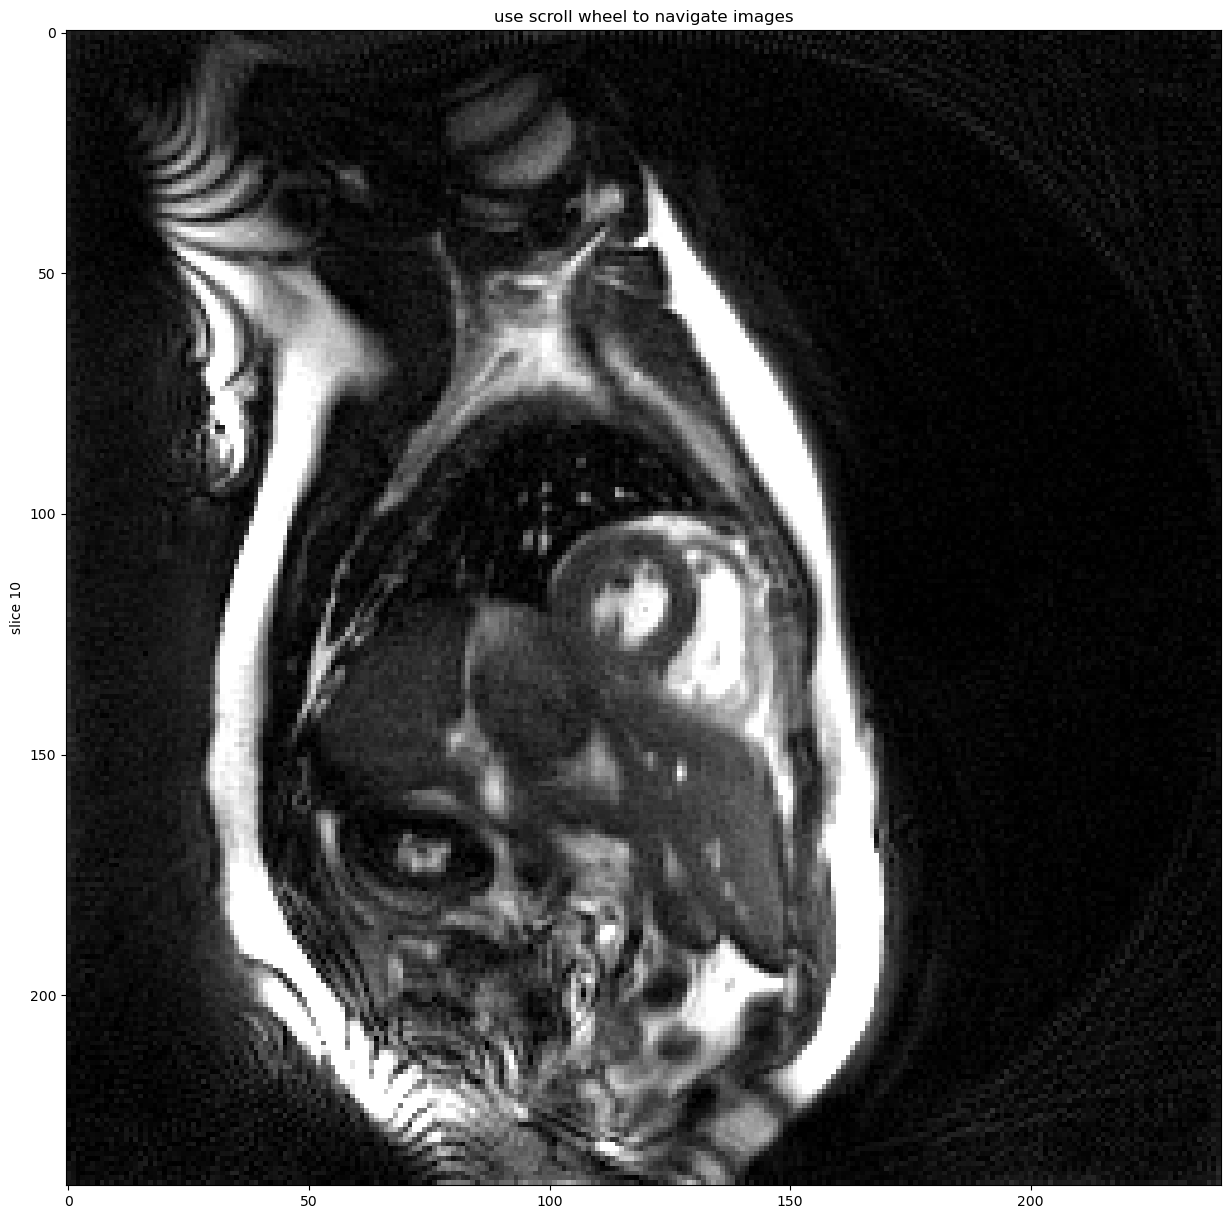

In [38]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind], cmap='gray', vmin=np.percentile(self.X[:, :, 0], 5), vmax=np.percentile(self.X[:, :, 0], 95))
        self.update()

    def onscroll(self, event):
        # print("%s %s" % (event.key, event.step))
        if event.key == 'right':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)


tracker = IndexTracker(ax, np.abs(img))

fig.canvas.mpl_connect('key_press_event', tracker.onscroll)
plt.show()


## Following does respiratory binning similar to the above method.

Text(0.5, 1.0, 'PT Respiratory bins')

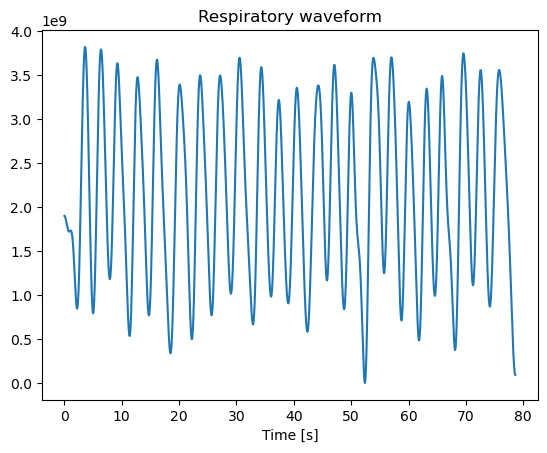

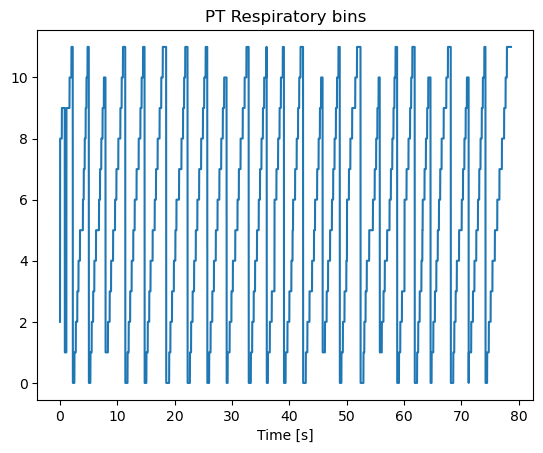

In [17]:
def generate_respiratory_bins2(resp_waveform: npt.NDArray[np.double], n_resp_bins: int, resp_discard: float = 0) -> npt.NDArray[np.int32]:
    resp_waveform = resp_waveform.astype(float)
    resp_wf_diff = np.diff(resp_waveform.astype(float), prepend=0)
    n_acq = resp_waveform.shape[0]
    n_resp_discard =  int(n_acq*resp_discard)
    resp_waveform2 = resp_waveform
    resp_waveform2[resp_wf_diff < 0] = 2*np.max(resp_waveform) - resp_waveform2[resp_wf_diff < 0]
    I_resp = np.argsort(resp_waveform2)
    I_resp_rev = np.argsort(I_resp)

    n_resp_per_bin = int((n_acq-n_resp_discard)//n_resp_bins)
    n_ext_resp = n_acq - n_resp_per_bin*n_resp_bins

    curr_bin_start = (n_ext_resp//2)
    resp_bins = np.zeros((n_acq,), dtype=int)
    resp_bins[:] = -1

    for bin_i in range(n_resp_bins):
        curr_bin_slc = np.s_[curr_bin_start:(curr_bin_start + n_resp_per_bin)]
        resp_bins[curr_bin_slc] = bin_i
        curr_bin_start += n_resp_per_bin

    resp_bins = resp_bins[I_resp_rev]
    return resp_bins


n_resp_bins = 12
resp_waveform = []

for wf in wf_list:
    if wf.getHead().waveform_id == 1025:
        resp_waveform = wf.data[0,:]
        resp_sampling_time = wf.getHead().sample_time_us*1e-6
        break

# resp_waveform = np.array(resp_waveform)

time_pt = np.arange(resp_waveform.shape[0])*resp_sampling_time

resp_bins = generate_respiratory_bins2(resp_waveform, n_resp_bins, 0.00)

plt.figure()
plt.plot(time_pt, resp_waveform)
plt.xlabel('Time [s]')
plt.title('Respiratory waveform')
plt.figure()
plt.plot(time_pt, resp_bins)
plt.xlabel('Time [s]')
plt.title('PT Respiratory bins')

In [40]:
# ksp_grps = [[0]*n_cardiac_bins]*n_resp_bins
# trj_grps = [[0]*n_cardiac_bins]*n_resp_bins
ksp_grps = []
trj_grps = []
n_min_arms = n_acq
n_max_arms = 0

for r_i in range(n_resp_bins):
    ksp_grps.append([])
    trj_grps.append([])
    for c_i in range(n_cardiac_bins):
        grp_idxs = (resp_bins==r_i) & (cardiac_bins==c_i)
        n_min_arms = min(n_min_arms, np.sum(grp_idxs))
        n_max_arms = max(n_max_arms, np.sum(grp_idxs))

        ksp_grps[r_i].append(data[:,:,grp_idxs])
        trj_grps[r_i].append(np.concatenate((coord[:,grp_idxs,:], np.zeros((coord.shape[0], np.sum(grp_idxs), 1))), axis=2))

print(f'There are {n_min_arms} arms per bin.')
# Second pass for discarding the excess arms.
for r_i in range(n_resp_bins):
    for c_i in range(n_cardiac_bins):
         ksp_grps[r_i][c_i] = ksp_grps[r_i][c_i][:,:,0:n_min_arms]
         trj_grps[r_i][c_i] = trj_grps[r_i][c_i][:,0:n_min_arms,:]

#       0           1           2           3           4           5
#   READ_DIM,   PHS1_DIM,   PHS2_DIM,   COIL_DIM,   MAPS_DIM,   TE_DIM,
#       6           7           8           9          10          11 
#   COEFF_DIM,  COEFF2_DIM, ITER_DIM,   CSHIFT_DIM, TIME_DIM,   TIME2_DIM
#      12          13          14      
#   LEVEL_DIM,  SLICE_DIM,  AVG_DIM

# Put respiratory into TIME_DIM [10] cardiac into TIME2_DIM [11]

ksp_grps = np.array(ksp_grps) # [nresp, ncard, nch, nsamp, narms]
ksp_grps = np.transpose(ksp_grps, (3, 4, 2, 0, 1)) # [nsamp, narms, nch, nresp, ncard] 
ksp_grps = ksp_grps[None,:,:,:,None,None,None,None,None,None,:,:]

trj_grps = np.array(trj_grps) # [nresp, ncard, nsamp, narms, 2]
trj_grps = np.transpose(trj_grps, (4, 2, 3, 0, 1)) # [2, nsamp, narms, nresp, ncard]
trj_grps = trj_grps[:,:,:,None,None,None,None,None,None,None,:,:]


There are 4 arms per bin.


In [48]:
lambda_tr = 1e-2 #0.000001
lambda_tc = 1e-2 #0.000001
n_iter = 1000
from scipy.signal.windows import tukey

ksp_win = tukey(2*nk, alpha=0.1)
ksp_win = ksp_win[None,(nk):,None,None,None,None,None,None,None,None,None,None]
# plt.plot(np.squeeze(ksp_win))
# img = bart.bart(1, f'pics -g -R T:3072:0:{lambda_tr} -d 4 -i {n_iter} -t',
#             trj_grps, ksp_grps*ksp_win, sens)
img = bart.bart(1, f'pics -g -e -r 0 -R T:1024:0:{lambda_tr} -R T:2048:0:{lambda_tc} -d 4 -i {n_iter} -t',
            trj_grps, ksp_grps*ksp_win*1e3, sens)
# img = bart.bart(1, f'pics -g -m -e -S -d 4 -i {n_iter} -t',
            # trj_grps, ksp_grps*ksp_win, sens)
img = np.squeeze(img)


GPU reconstruction
[  1 1500   4  15   1   1   1   1   1   1  12  20   1   1   1   1 ]
[240 240   1  15   1   1   1   1   1   1  12  20   1   1   1   1 ]
ksp : [  1 1500   4  15   1   1   1   1   1   1  12  20   1   1   1   1 ]
cim : [240 240   1  15   1   1   1   1   1   1  12  20   1   1   1   1 ]
traj: [  3 1500   4   1   1   1   1   1   1   1  12  20   1   1   1   1 ]
wgh : [  1 1500   4   1   1   1   1   1   1   1  12  20   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 1500   4   1   1   1   1   1   1   1  12  20   1   1   1   1   1 ]
cim : [480 480   1   1   1   1   1   1   1   1  12  20   1   1   1   1   1 ]
traj: [  3 1500   4   1   1   1   1   1   1   1  12  20   1   1   1   1   1 ]
wgh : [  1 1500   4   1   1   1   1   1   1   1  12  20   1   1   1   1   1 ]
Scaling: 0.873983  (max = 1.430420/p90 = 0.873983/median = 0.561621)
Inverse scaling of the data: 0.873983
Maximum eigenvalue: 2.28e+01
TV regularization: 0.010000
TV regularization: 0.010000
Regularization terms: 2, Su

In [42]:
np.max(sens)

(0.91323465-0.0125150755j)

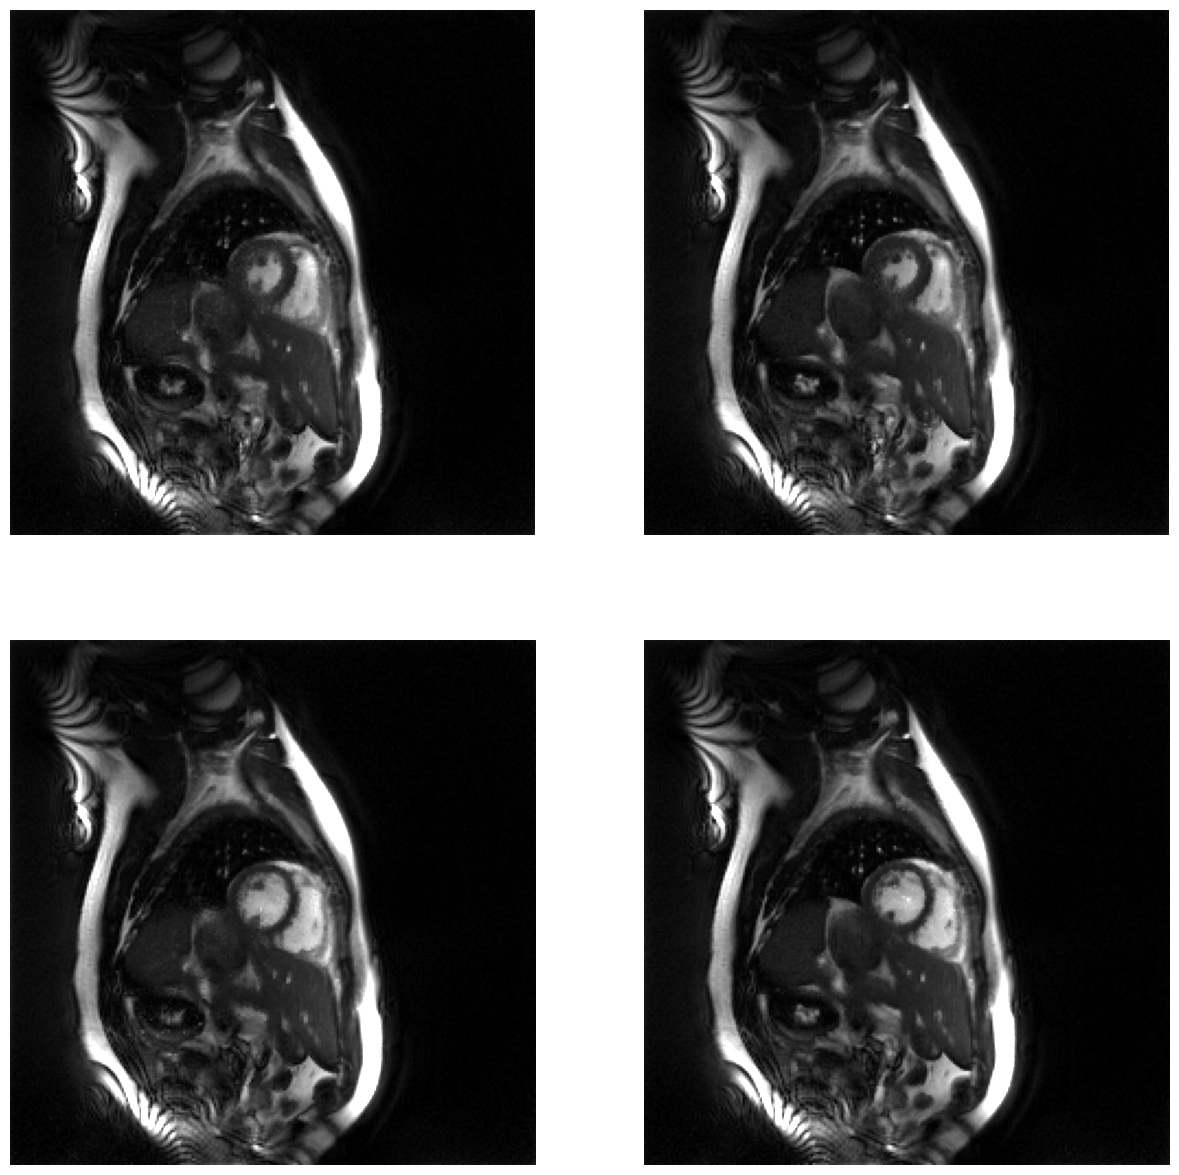

In [49]:
plt.rcParams['figure.figsize'] = [15, 15]
img = np.abs(np.squeeze(img))
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(np.abs(img[:,:,2,10]), cmap = 'gray', vmin=np.percentile(img[:,:, 0, 0], 2), vmax=np.percentile(img[:,:, 0, 0], 98))
axs[0,0].set_axis_off()
axs[0,1].imshow(np.abs(img[:,:,10,10]), cmap = 'gray', vmin=np.percentile(img[:,:, 0, 0], 2), vmax=np.percentile(img[:,:, 0, 0], 98))
axs[0,1].set_axis_off()
axs[1,0].imshow(np.abs(img[:,:,2,18]), cmap = 'gray', vmin=np.percentile(img[:,:, 0, 0], 2), vmax=np.percentile(img[:,:, 0, 0], 98))
axs[1,0].set_axis_off()
axs[1,1].imshow(np.abs(img[:,:,10,18]), cmap = 'gray', vmin=np.percentile(img[:,:, 0, 0], 2), vmax=np.percentile(img[:,:, 0, 0], 98))
axs[1,1].set_axis_off()

from scipy.io import savemat
savemat('xdgraspXD.mat', {'imgrasp': img})